# Partial Dependence Plots (PDP)
Partial Dependence Plots (PDP) isolate a single variable and single class (probability), and demonstrate the effect of varying that variable on that class, thereby showing the dependence of that class prediction on the variable. 

PDPs work by systematically increasing the variable (usually within the range of its min and max) and measuring the change in the model prediction. The plots show the class prediction probability for each value of the chosen variable. Each class prediction probability is an average across all data points for each value of the chosen variable.

To break it down in code:

In [47]:
# Install libraries before running:
# !pip install numpy pandas matplotlib seaborn scipy scikit-learn xgboost shap alepython

Import libraries & prepare data

In [48]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from scipy.interpolate import RectBivariateSpline
from sklearn.base import is_classifier

# Dataset
from sklearn.datasets import load_iris

# Models
import xgboost as xgb
from sklearn.model_selection import train_test_split

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(1)

In [49]:
# Load dataset into dataframes
data = load_iris()

df = pd.DataFrame(data.data, columns=data.feature_names) # Full dataframe

df["target"] = data.target
y = pd.DataFrame(data.target, columns=["target"])  

X = df.drop(columns=["target"])
X = pd.DataFrame(data.data, columns=data.feature_names) 


print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [50]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fit the model (using XGBoost)

In [51]:
model = xgb.XGBClassifier().fit(X_train, y_train)

**Begin preparation for PDP plot.** 
Select the feature index and class

In [52]:
# PDP plot, numpy implementation from https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb
feature_index = 2  # The third feature
target_class = 2 # The third class

Create a range of values of that feature in a list. The feature values go from the minimum to the maximum value found in the data.

In [53]:
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=80)

# np.linspace evenly spaces the values between the min and max, for num=80 values.
# X.iloc[:, feature_index] selects all the values of the target feature. Then we determine the np.min and np.max.

print(feature_values)

[1.         1.07468354 1.14936709 1.22405063 1.29873418 1.37341772
 1.44810127 1.52278481 1.59746835 1.6721519  1.74683544 1.82151899
 1.89620253 1.97088608 2.04556962 2.12025316 2.19493671 2.26962025
 2.3443038  2.41898734 2.49367089 2.56835443 2.64303797 2.71772152
 2.79240506 2.86708861 2.94177215 3.0164557  3.09113924 3.16582278
 3.24050633 3.31518987 3.38987342 3.46455696 3.53924051 3.61392405
 3.68860759 3.76329114 3.83797468 3.91265823 3.98734177 4.06202532
 4.13670886 4.21139241 4.28607595 4.36075949 4.43544304 4.51012658
 4.58481013 4.65949367 4.73417722 4.80886076 4.8835443  4.95822785
 5.03291139 5.10759494 5.18227848 5.25696203 5.33164557 5.40632911
 5.48101266 5.5556962  5.63037975 5.70506329 5.77974684 5.85443038
 5.92911392 6.00379747 6.07848101 6.15316456 6.2278481  6.30253165
 6.37721519 6.45189873 6.52658228 6.60126582 6.67594937 6.75063291
 6.82531646 6.9       ]


Prepare an array to store average predictions and duplicate the dataset so that we can modify the target feature without affecting the original data

In [54]:
# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Duplicate the dataset to modify feature values
X_modified = X.copy()

**This is the key step.** It will iterate over the range of feature values, 80 values between the min (4.3) and max (7.9).

For each, work out what the model will predict if we set that feature to that value for all data points. 

Average the prediction value across all the data points for each feature value, so we get one prediction value per feature value.

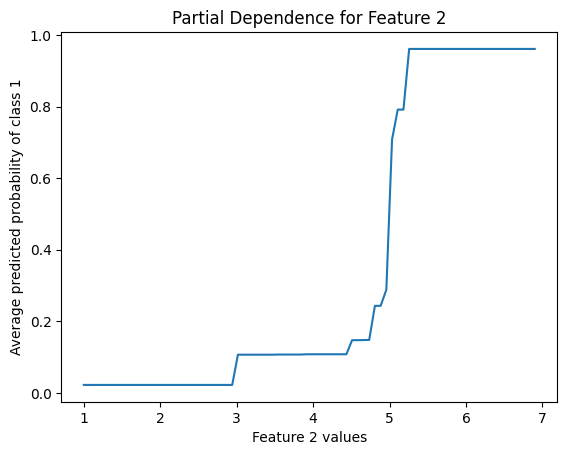

In [55]:
# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for all instances
    X_modified.iloc[:, feature_index] = value

    # Predict using the modified dataset. 
    # Essentially, run the model for each row of data, but the chosen feature is set to a single value for every row.
    predictions = model.predict_proba(X_modified)[:, target_class]

    # Calculate average prediction for the current feature value
    average_predictions[i] = np.mean(predictions)

# Plot the partial dependence for the chosen feature
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature {feature_index} values')
plt.ylabel('Average predicted probability of class 1')
plt.title(f'Partial Dependence for Feature {feature_index}')
plt.show()

This plot is pretty simple to interpret. Feature 2 values significantly affect the prediction of class 2, essentially making the prediction go from almost 0 to almost 1 when going from a value of 4 to 5. This is useful as it indicates that class 2 is highly dependent on feature 2.

To make clear what we mean by averaging the value across all data points for each feature value, let's break down a single iteration in the for loop.

In [57]:
# Set the feature value to one example value (4.3, the minimum)
value = 5.1
X_modified.iloc[:, feature_index] = value

print(X_modified)
print("\nWe can see that we have set all of feature value 2 to 5.1, and there are 150 data points\n")

# Predict using the modified dataset
predictions = model.predict_proba(X_modified)[:, target_class]

print(predictions)
print("\nThus, we have 150 predictions for each data point\n")

# Calculate average prediction for the current feature value
average_predictions[i] = np.mean(predictions)
print("Average prediction value =", average_predictions[i])
print("\nSo we take the average of those 150 values to get the single prediction value for that feature value. Then repeat for the other 79, and plot.")

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                5.1               0.2
1                  4.9               3.0                5.1               0.2
2                  4.7               3.2                5.1               0.2
3                  4.6               3.1                5.1               0.2
4                  5.0               3.6                5.1               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.1               2.3
146                6.3               2.5                5.1               1.9
147                6.5               3.0                5.1               2.0
148                6.2               3.4                5.1               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]

We can see that we have set all of feat